In [1]:
!pip install ultralytics

In [2]:
import torch

# Confirming GPU is active for fast video processing
print(f"Using GPU: {torch.cuda.is_available()}")

Using GPU: True


In [3]:
# # Loading the Model
# model = YOLO('yolov8m.pt')

# VIDEO_PATH = "/content/drive/MyDrive/AI_Object_Detection_Project_P14/driver-action-recognition.mp4"

# # 2. Run inference on the video
# result_1 = model.predict(source = VIDEO_PATH,
#                          conf = 0.30,
#                          save = True,
#                          stream = True,
#                          device = 0
#                         )

# # 3. Iterate through results (Optional - if you want to print stats)
# for result in result_1:
#   boxes = result.boxes
#   print(f"Detected {len(boxes)} objects in this frame")

In [4]:
import time
from ultralytics import YOLO
import torch
import numpy as np

# --- 1. CONFIGURATION ---
VIDEO_PATH = "/content/drive/MyDrive/AI_Object_Detection_Project_P14/driver-action-recognition.mp4"
MODEL_NAME = "yolo11x.pt"

print(f"[INFO] Loading Model: {MODEL_NAME}...")
model_2 = YOLO(MODEL_NAME)

# --- 2. STATS CONTAINERS ---
stats = {
    "total_frames": 0,
    "confidences": [],     # To calculate avg accuracy
    "class_counts": {},    # To count "Person", "Tie", etc.
    "inference_times": []  # To calculate Model FPS
}

# --- 3. RUN INFERENCE ---
print(f"[INFO] Starting Inference on {VIDEO_PATH}...")
start_wall_time = time.time()

# Run with stream=True (Generator)
# We set verbose=False to stop it from printing every single frame log to the console
results_generator = model_2.predict(
    source=VIDEO_PATH,
    conf=0.30,
    save=True,
    stream=True,
    device=0,
    verbose=False
)

# --- 4. PROCESSING LOOP ---
for result in results_generator:
    stats["total_frames"] += 1

    # A. Track Speed (Sum of preprocess + inference + postprocess)
    # result.speed comes in milliseconds (ms)
    frame_process_time = sum(result.speed.values())
    stats["inference_times"].append(frame_process_time)

    # B. Track Objects & Confidence
    # result.boxes contains all detections for this frame
    for box in result.boxes:
        # Get Confidence (0.0 - 1.0)
        conf = box.conf.item()
        stats["confidences"].append(conf)

        # Get Class Name (e.g., 'person')
        cls_id = int(box.cls.item())
        class_name = result.names[cls_id]

        # Update Counts
        stats["class_counts"][class_name] = stats["class_counts"].get(class_name, 0) + 1

    # Optional: Print progress every 20 frames to know it's working
    if stats["total_frames"] % 20 == 0:
        print(f"Processed {stats['total_frames']} frames...")

# --- 5. CALCULATE & PRINT SUMMARY ---
end_wall_time = time.time()
total_wall_time = end_wall_time - start_wall_time

# Calculations
avg_model_inference = np.mean(stats["inference_times"]) # ms
model_fps = 1000 / avg_model_inference
real_fps = stats["total_frames"] / total_wall_time
avg_confidence = np.mean(stats["confidences"]) if stats["confidences"] else 0

print("\n" + "="*50)
print(f"🏆 YOLOv11x PERFORMANCE REPORT")
print("="*50)
print(f"1. Total Frames Processed: {stats['total_frames']}")
print(f"2. Total Wall Time:        {total_wall_time:.2f} seconds")
print(f"3. Real-World Speed:       {real_fps:.2f} FPS (Includes processing overhead)")
print(f"4. Model Inference Speed:  {model_fps:.2f} FPS (Pure GPU speed)")
print(f"5. Average Confidence:     {avg_confidence:.2%} (Model Certainty)")
print("-" * 50)
print("6. Total Objects Detected:")
for obj, count in stats["class_counts"].items():
    print(f"   - {obj}: {count}")
print("="*50)

[INFO] Loading Model: yolo11x.pt...
[INFO] Starting Inference on /content/drive/MyDrive/AI_Object_Detection_Project_P14/driver-action-recognition.mp4...
Processed 20 frames...
Processed 40 frames...
Processed 60 frames...
Processed 80 frames...
Processed 100 frames...
Processed 120 frames...
Processed 140 frames...
Processed 160 frames...
Processed 180 frames...
Processed 200 frames...
Processed 220 frames...
Processed 240 frames...
Processed 260 frames...
Processed 280 frames...
Processed 300 frames...
Processed 320 frames...
Processed 340 frames...
Processed 360 frames...
Processed 380 frames...
Processed 400 frames...
Processed 420 frames...
Processed 440 frames...
Processed 460 frames...
Processed 480 frames...
Processed 500 frames...
Processed 520 frames...
Processed 540 frames...
Processed 560 frames...
Processed 580 frames...
Processed 600 frames...
Processed 620 frames...
Processed 640 frames...
Processed 660 frames...
Processed 680 frames...
Processed 700 frames...
Processed 7

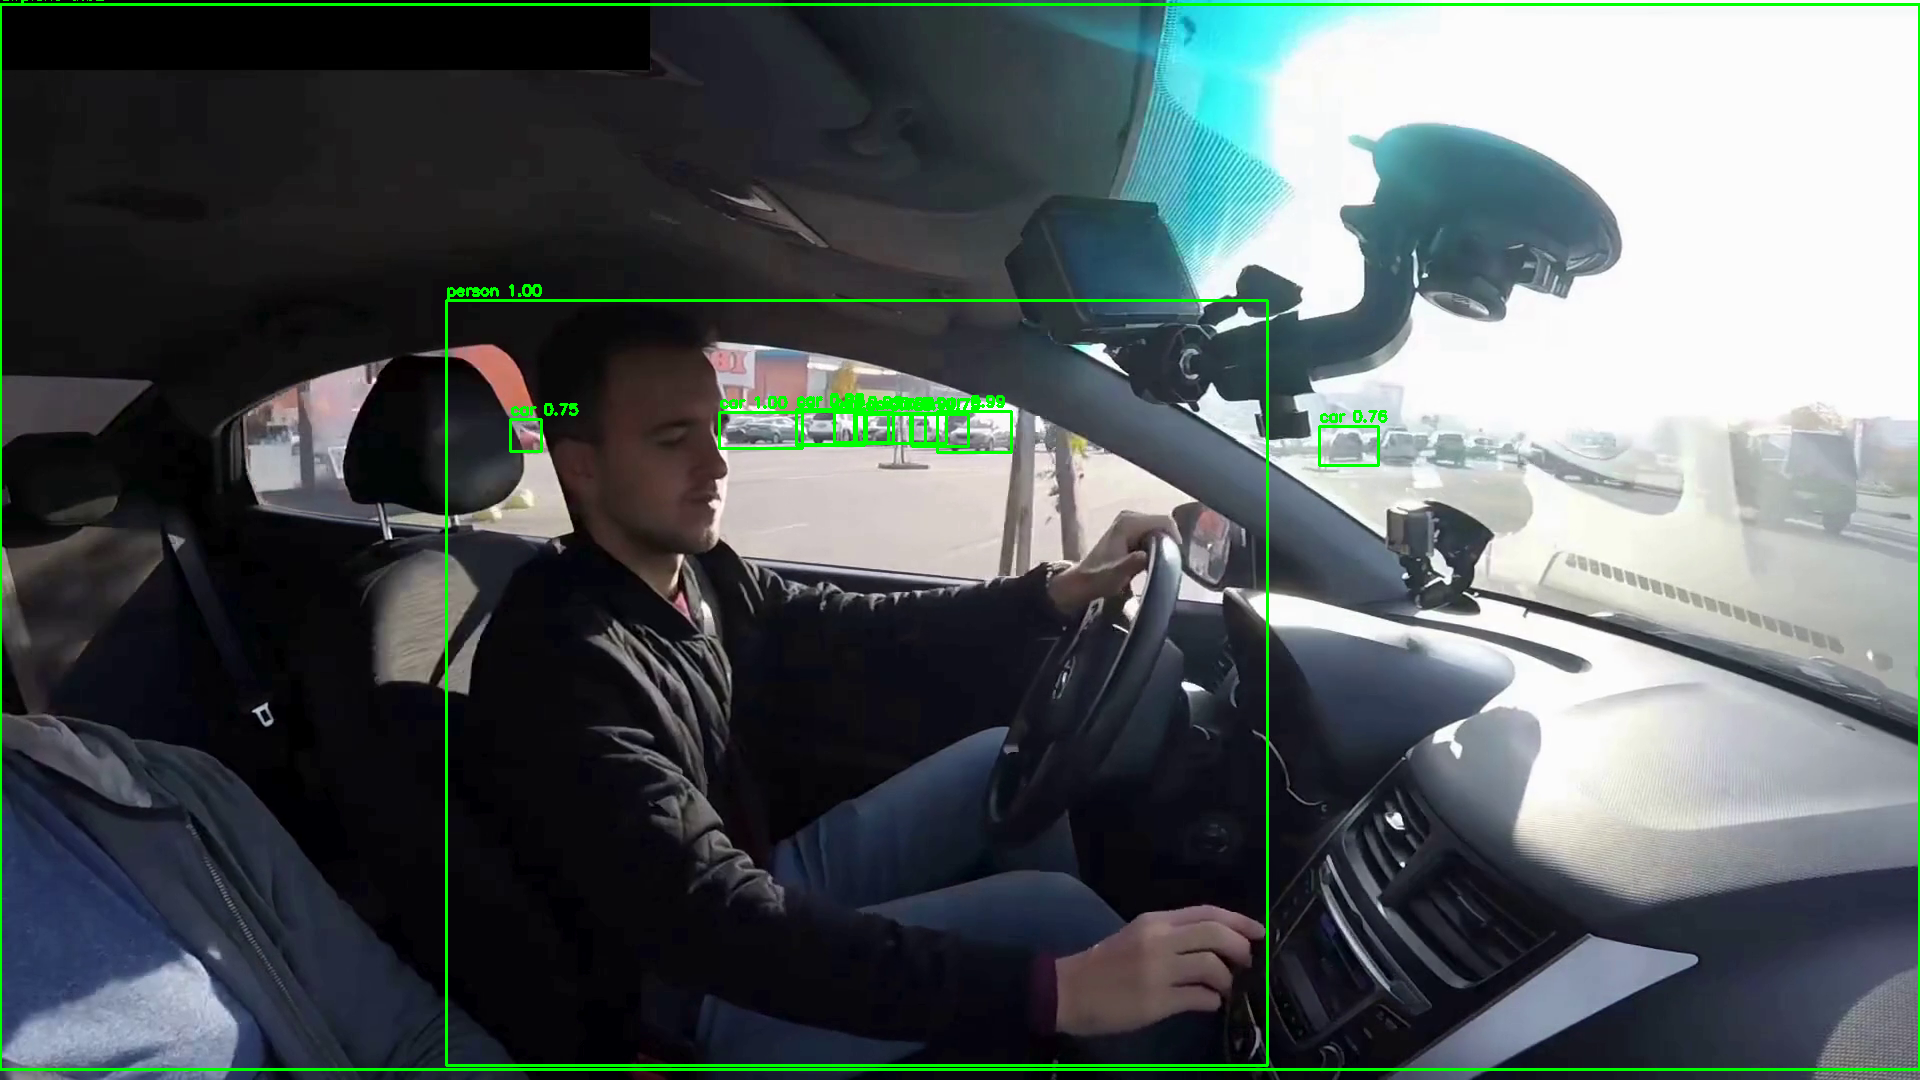

Processing Frame: 1510

📊 DETR PERFORMANCE REPORT
1. Total Frames Processed: 1512
2. Total Time Taken:       365.88 seconds
3. Average FPS:            4.13 FPS
4. Average Confidence:     89.77% (Model Certainty)
----------------------------------------
5. Total Objects Detected:
   - car: 7806
   - airplane: 256
   - person: 1920
   - truck: 455
   - traffic light: 33
   - motorcycle: 519
   - bus: 3
   - cell phone: 676
   - tv: 46
   - sports ball: 3
   - clock: 32
   - backpack: 9
   - suitcase: 36
   - handbag: 7
   - stop sign: 10
   - laptop: 3
   - chair: 40
   - bicycle: 3
   - bed: 6
   - horse: 1
   - tie: 6
   - dog: 1


In [6]:
import cv2
import time
import numpy as np
from PIL import Image
from transformers import pipeline
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# --- CONFIGURATION ---
VIDEO_PATH = '/content/drive/MyDrive/AI_Object_Detection_Project_P14/driver-action-recognition.mp4'
OUTPUT_PATH = '/content/drive/MyDrive/AI_Object_Detection_Project_P14/runs2/detr_stats_output.avi'
MODEL_NAME = "facebook/detr-resnet-50"

# --- SETUP ---
print(f"[INFO] Loading model: {MODEL_NAME}...")
detector = pipeline("object-detection", model=MODEL_NAME)
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"❌ Error: Cannot open {VIDEO_PATH}")
    exit()

# Stats Containers
all_scores = []      # To calculate Average Confidence
object_counts = {}   # To count how many Cars, People, etc.
frame_times = []     # To calculate FPS stability

# Video Writers
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'MJPG'), fps, (frame_width, frame_height))

print("[INFO] Processing Video... Please wait.")
start_time = time.time()
frame_id = 0

try:
    while cap.isOpened():
        loop_start = time.time()
        ret, frame = cap.read()
        if not ret:
            break

        frame_id += 1

        # Inference
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        results = detector(pil_image)

        # Process Detections
        frame_scores = []
        for r in results:
            label = r['label']
            score = r['score']

            if score > 0.7: # Only count confident detections
                # Update Stats
                all_scores.append(score)
                object_counts[label] = object_counts.get(label, 0) + 1

                # Draw
                box = r['box']
                x1, y1, x2, y2 = int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"{label} {score:.2f}", (x1, y1-5), 0, 0.5, (0, 255, 0), 2)

        out.write(frame)

        # Display every 10th frame to save time
        if frame_id % 10 == 0:
            clear_output(wait=True)
            cv2_imshow(frame)
            print(f"Processing Frame: {frame_id}")

        # Track Loop Time
        frame_times.append(time.time() - loop_start)

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    total_time = time.time() - start_time
    cap.release()
    out.release()

    # --- 🧮 CALCULATE FINAL STATS ---
    avg_fps = frame_id / total_time
    avg_conf = sum(all_scores) / len(all_scores) if all_scores else 0
    unique_objects = list(object_counts.keys())

    print("\n" + "="*40)
    print(f"📊 DETR PERFORMANCE REPORT")
    print("="*40)
    print(f"1. Total Frames Processed: {frame_id}")
    print(f"2. Total Time Taken:       {total_time:.2f} seconds")
    print(f"3. Average FPS:            {avg_fps:.2f} FPS")
    print(f"4. Average Confidence:     {avg_conf:.2%} (Model Certainty)")
    print("-" * 40)
    print("5. Total Objects Detected:")
    for obj, count in object_counts.items():
        print(f"   - {obj}: {count}")
    print("="*40)